In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
%matplotlib inline
from fbprophet import Prophet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
df=pd.read_csv("data/sorted_data.csv").iloc[:,1:]

In [3]:
df

,DateTime,AQI-IN,AQI-US,PM25,PM10,PM1,AQI-IN(2),AQI-US(2),PM25(2),PM10(2),PM1(2),Temp(cel),Hum,Noise,Light
0,2019-11-12 00:00:00,668.76,499.96,541.09,645.17,227.84,816.00,500.00,595.00,763.00,270.00,19.66,62.00,42.39,48332.0
1,2019-11-12 01:00:00,672.40,500.00,548.99,648.20,233.32,852.99,500.00,610.07,792.48,279.21,19.74,62.92,41.83,48332.0
2,2019-11-12 02:00:00,696.34,500.00,567.10,667.22,237.52,882.38,500.00,628.13,815.98,287.19,20.00,63.18,46.24,48332.0
3,2019-11-12 03:00:00,754.72,500.00,602.54,714.00,242.85,898.00,500.00,675.00,829.00,295.00,18.35,65.89,40.05,48332.0
4,2019-11-12 04:00:00,884.74,500.00,662.52,818.20,251.60,898.00,500.00,675.00,829.00,295.00,18.14,66.43,39.55,48332.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2020-02-09 19:00:00,379.22,272.65,223.41,251.66,132.72,302.00,185.00,123.00,142.00,76.00,18.04,66.07,46.18,48332.0
2156,2020-02-09 20:00:00,403.84,303.74,255.52,287.45,144.59,386.89,284.95,233.93,286.49,135.12,17.04,71.05,48.36,48332.0
2157,2020-02-09 21:00:00,414.45,315.31,269.58,312.97,144.94,403.00,304.00,255.00,315.00,146.00,16.68,74.01,49.36,48332.0
2158,2020-02-09 22:00:00,429.09,329.78,288.00,333.39,152.60,452.72,355.56,319.46,408.92,175.47,16.11,78.23,45.22,48332.0


In [4]:
df.dtypes

DateTime      object
AQI-IN       float64
AQI-US       float64
PM25         float64
PM10         float64
PM1          float64
AQI-IN(2)    float64
AQI-US(2)    float64
PM25(2)      float64
PM10(2)      float64
PM1(2)       float64
Temp(cel)    float64
Hum          float64
Noise        float64
Light        float64
dtype: object

In [5]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')

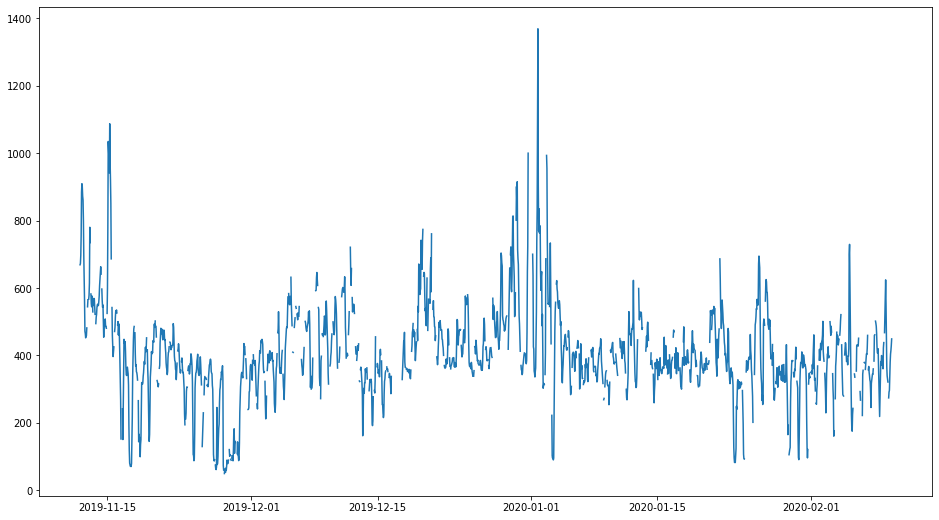

In [6]:
plt.figure(figsize=(16,9))
plt.plot(df["AQI-IN"])

In [7]:
ts=df["AQI-IN"].interpolate('linear')
ts.index=df.index

In [9]:
len_train=1680
ts=df.iloc[0:len_train, :]["AQI-IN"].interpolate('linear')
test=df.iloc[len_train:len_train+24*7,:]["AQI-IN"].interpolate('linear')

In [10]:
model_season_trend = sm.tsa.UnobservedComponents(
    ts,
    'local linear trend',
    seasonal=24
)

result_season_trend = model_season_trend.fit(
    method='bfgs', 
    maxiter=500, 
    start_params=model_season_trend.fit(method='nm', maxiter=500).params,
)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



Optimization terminated successfully.
         Current function value: 5.128081
         Iterations: 350
         Function evaluations: 609
Optimization terminated successfully.
         Current function value: 5.128081
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


In [11]:
result_season_trend.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Unobserved Components Results                            
=====================================================================================
Dep. Variable:                        AQI-IN   No. Observations:                 1680
Model:                    local linear trend   Log Likelihood               -8615.176
                   + stochastic seasonal(24)   AIC                          17238.352
Date:                       Thu, 13 Feb 2020   BIC                          17259.999
Time:                               18:17:54   HQIC                         17246.377
Sample:                           11-12-2019                                         
                                - 01-20-2020                                         
Covariance Type:                         opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.749e-08     22.526   7.76e-10      1.000     -44.150      44.150
sigma2.level      1829.8809     49.532     36.944      0.000    1732.801    1926.961
sigma2.trend      3.135e-12      0.018   1.77e-10      1.000      -0.035       0.035
sigma2.seasonal   8.906e-11      0.138   6.44e-10      1.000      -0.271       0.271
===================================================================================
Ljung-Box (Q):                      658.34   Jarque-Bera (JB):             18341.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

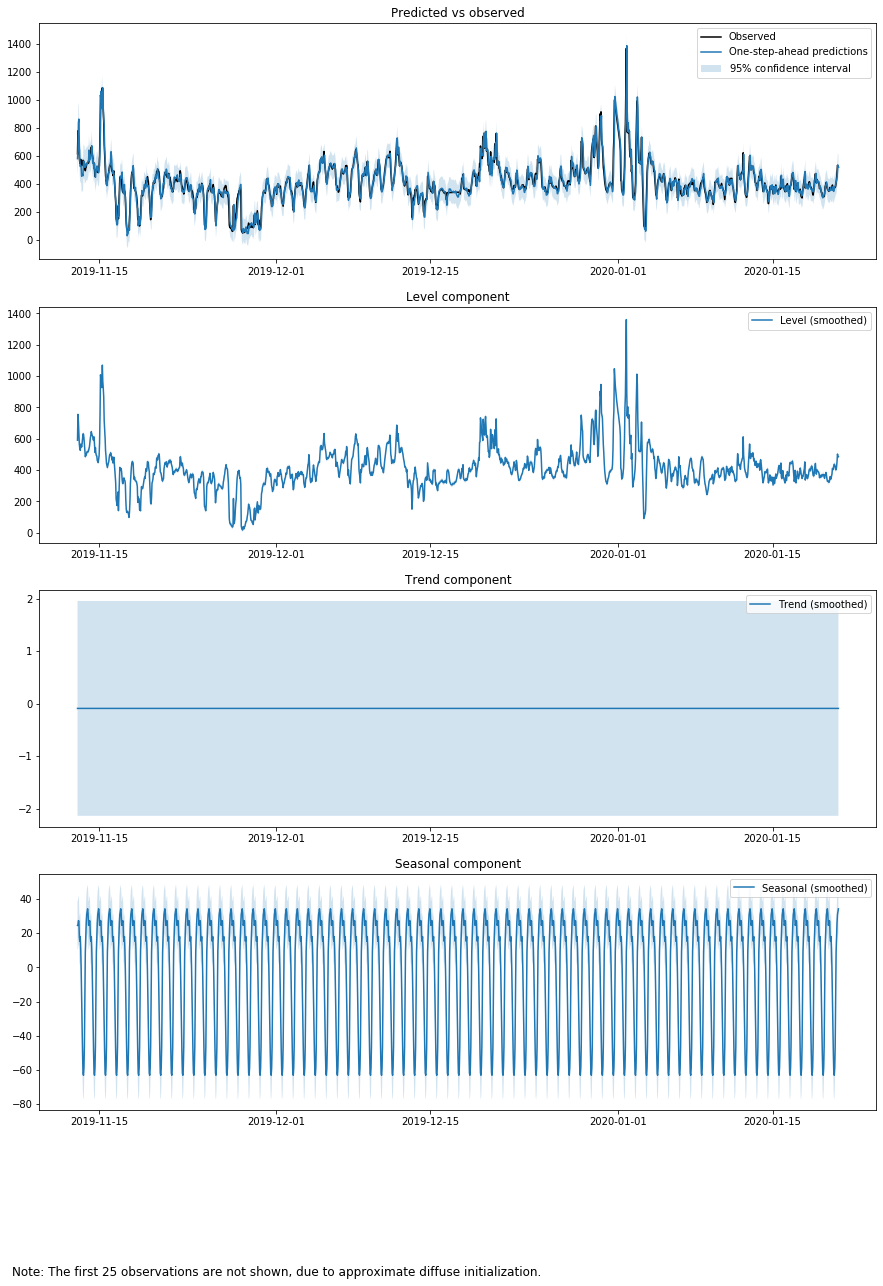

In [12]:
rcParams['figure.figsize'] = 15, 20
fig = result_season_trend.plot_components()


# 自動化

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



Optimization terminated successfully.
         Current function value: 5.130508
         Iterations: 105
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: 5.130508
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
ーーーーーーーーーー2020-01-21 00:00:00〜2020-01-27 23:00:00の予測ーーーーーーーーーー


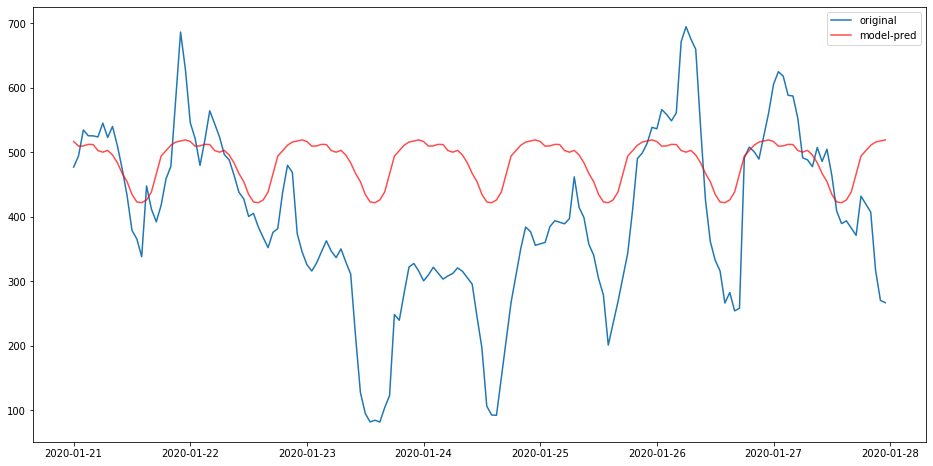

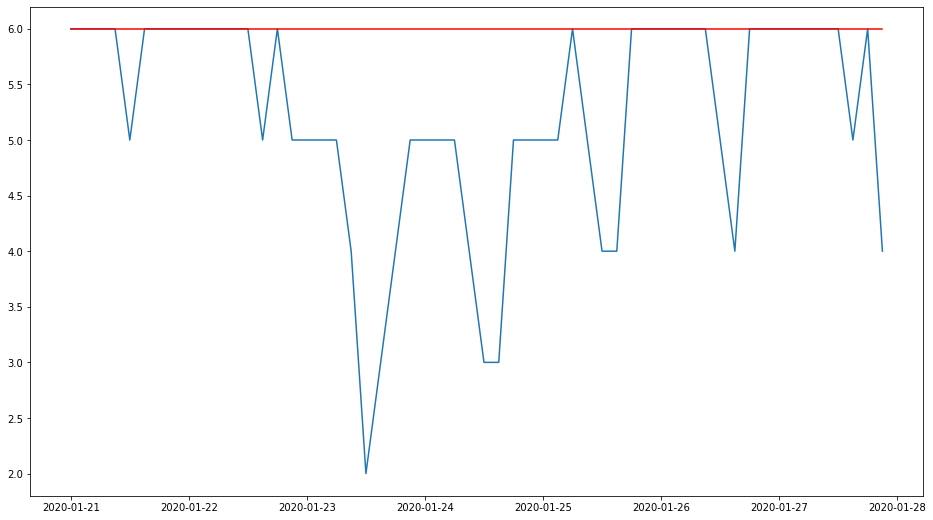

0.7857142857142857


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



Optimization terminated successfully.
         Current function value: 5.131955
         Iterations: 108
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: 5.131955
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
ーーーーーーーーーー2020-01-22 00:00:00〜2020-01-28 23:00:00の予測ーーーーーーーーーー


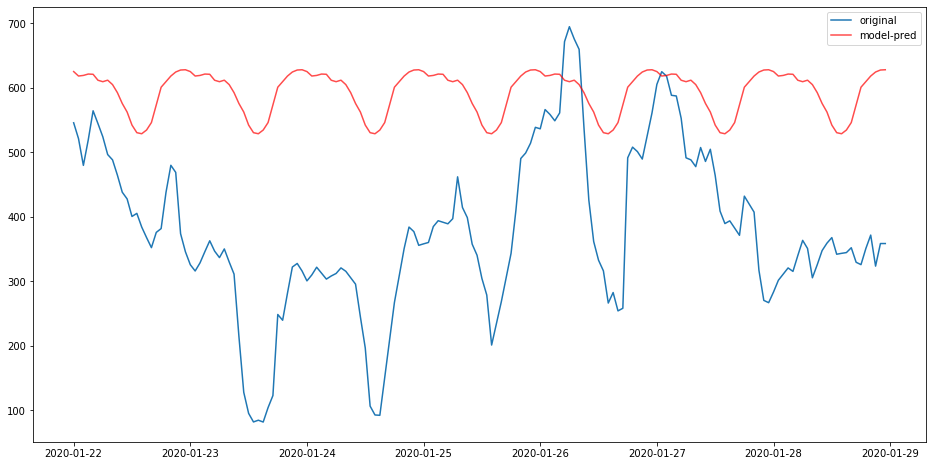

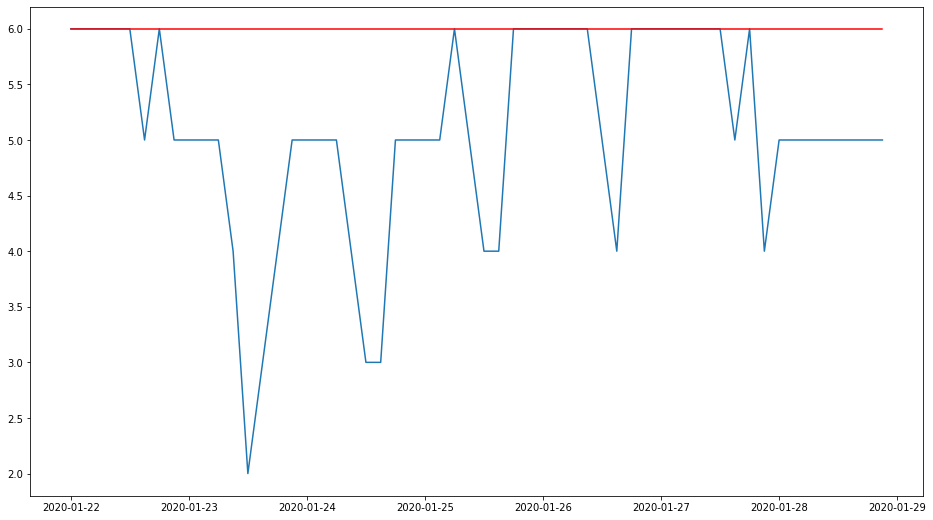

0.9107142857142857


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



Optimization terminated successfully.
         Current function value: 5.130376
         Iterations: 112
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: 5.130376
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
ーーーーーーーーーー2020-01-23 00:00:00〜2020-01-29 23:00:00の予測ーーーーーーーーーー


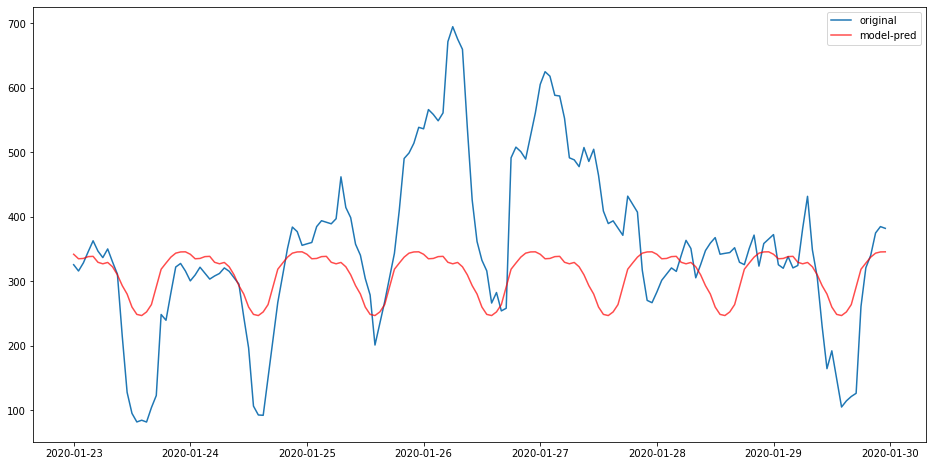

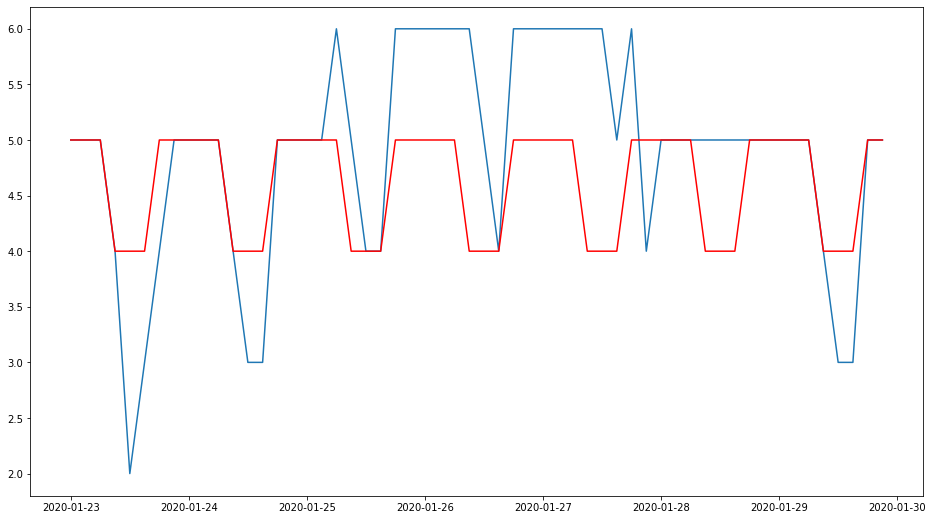

0.5892857142857143


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



Optimization terminated successfully.
         Current function value: 5.128206
         Iterations: 108
         Function evaluations: 201
Optimization terminated successfully.
         Current function value: 5.128206
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
ーーーーーーーーーー2020-01-24 00:00:00〜2020-01-30 23:00:00の予測ーーーーーーーーーー


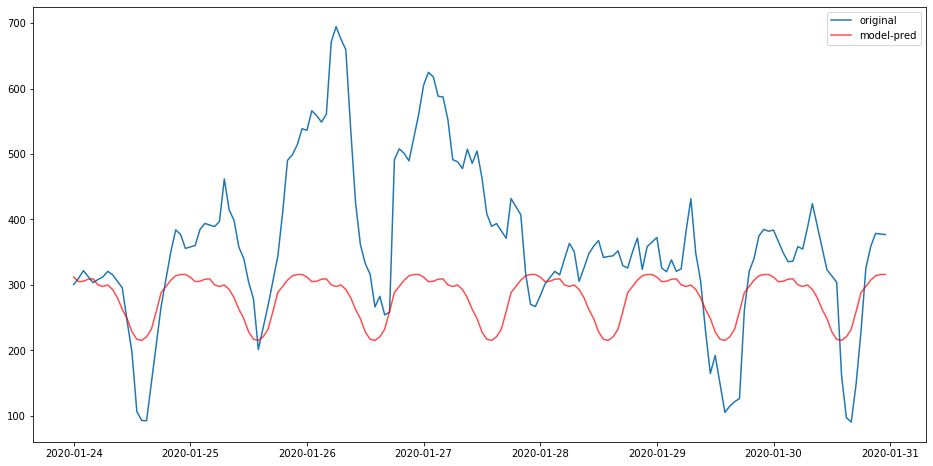

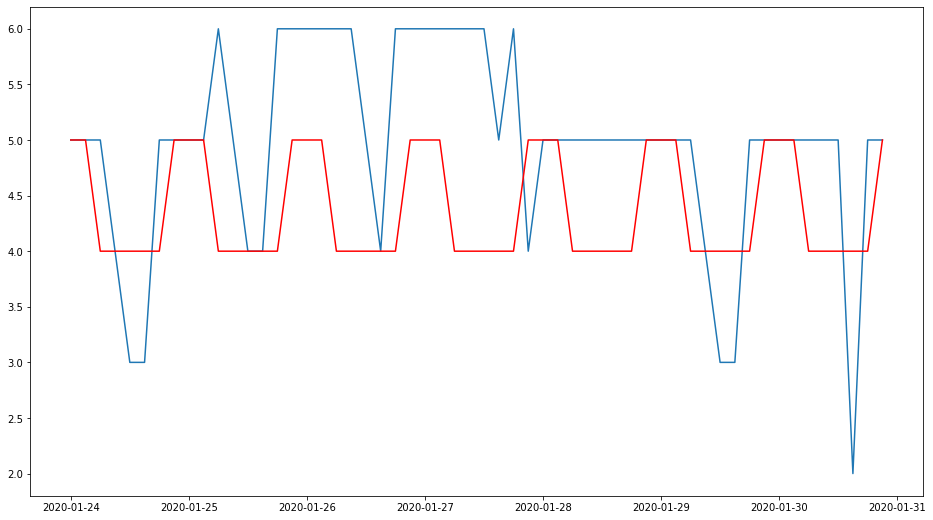

0.8392857142857143


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



Optimization terminated successfully.
         Current function value: 5.124689
         Iterations: 110
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: 5.124689
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
ーーーーーーーーーー2020-01-25 00:00:00〜2020-01-31 23:00:00の予測ーーーーーーーーーー


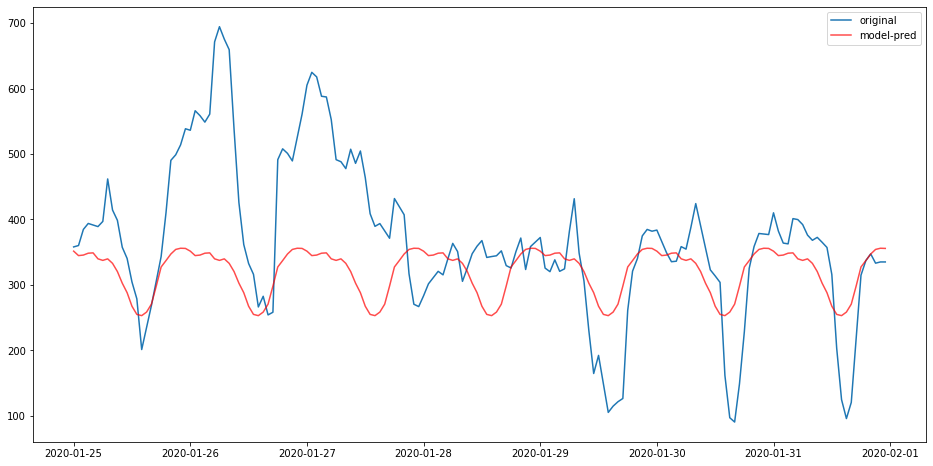

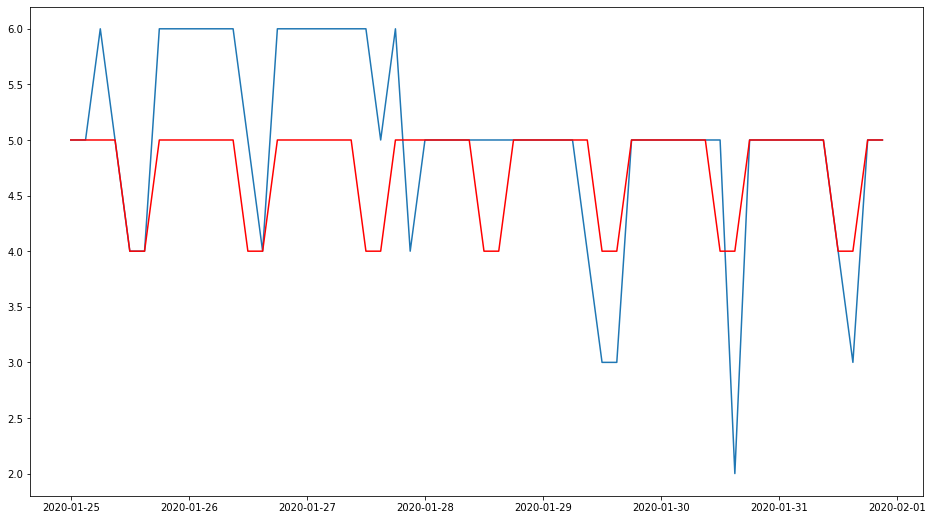

0.5


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



Optimization terminated successfully.
         Current function value: 5.122244
         Iterations: 109
         Function evaluations: 205
Optimization terminated successfully.
         Current function value: 5.122244
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
ーーーーーーーーーー2020-01-26 00:00:00〜2020-02-01 23:00:00の予測ーーーーーーーーーー


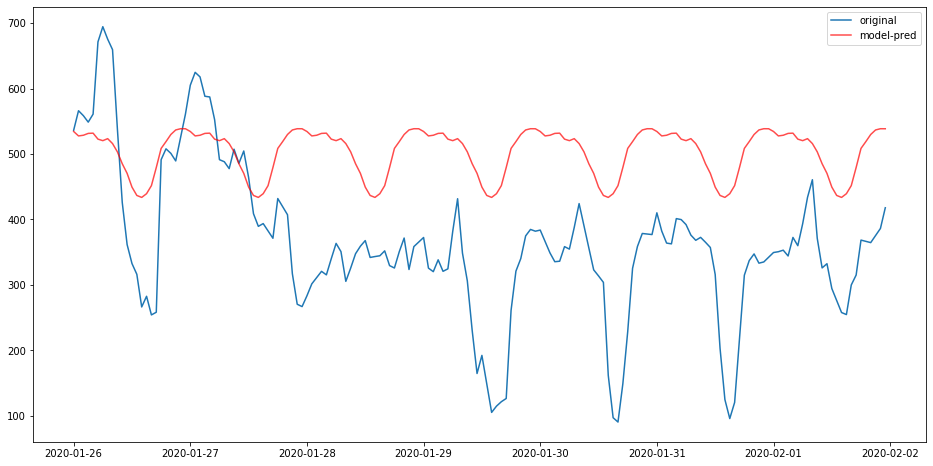

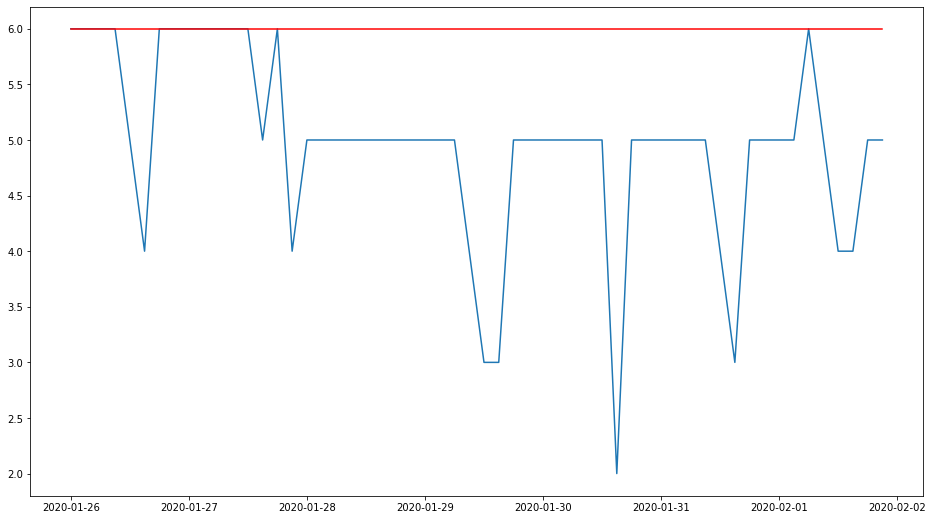

1.0357142857142858


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



Optimization terminated successfully.
         Current function value: 5.129825
         Iterations: 114
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: 5.129825
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
ーーーーーーーーーー2020-01-27 00:00:00〜2020-02-02 23:00:00の予測ーーーーーーーーーー


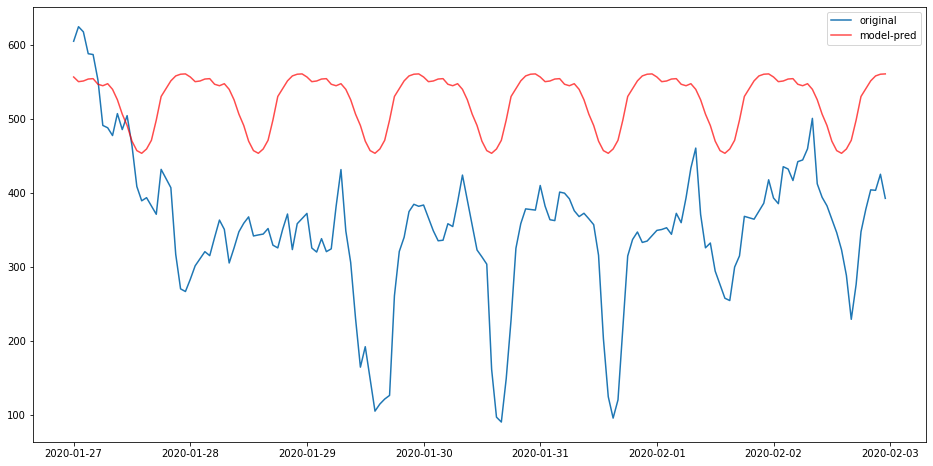

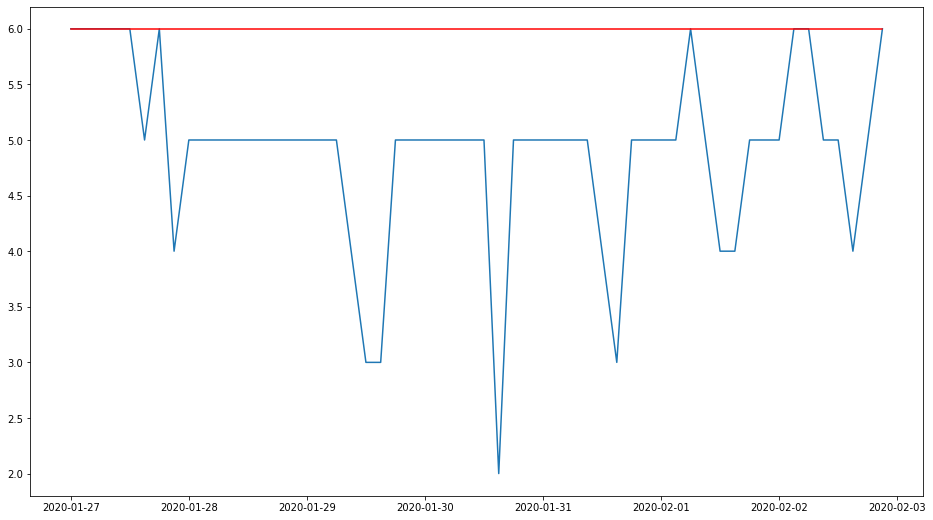

1.0892857142857142
[0.7857142857142857, 0.9107142857142857, 0.5892857142857143, 0.8392857142857143, 0.5, 1.0357142857142858, 1.0892857142857142]
0.8214285714285714


In [30]:
def aqi_numeric(x):
    if x>=0 and x<=50:
        return 1
    elif x>50 and x<=100:
        return 2
    elif x>100 and x<=200:
        return 3
    elif x>200 and x<=300:
        return 4
    elif x>300 and x<=400:
        return 5
    elif x>400 :
        return 6

#トレーニングデータの数(70日*24)
len_train=1680

score=[]

#1日ずらしながら7回精度評価を行う
for i in range(7):

    #train-testの分割
    ts=df.iloc[0:len_train, :]["AQI-IN"].interpolate('linear')
    test=df.iloc[len_train:len_train+24*7,:]["AQI-IN"].interpolate('linear')
    
    model_season_trend = sm.tsa.UnobservedComponents(
        ts,
        #'local linear trend',
        "local level",
        seasonal=24
    )

    result_season_trend = model_season_trend.fit(
        method='bfgs', 
        maxiter=500, 
        start_params=model_season_trend.fit(method='nm', maxiter=500).params,
    )


    #現在の時間
    now=ts.index[-1]

    #１時間後から7日後まで予測するための時間の作成
    forecast_1hour = now + datetime.timedelta(hours=1)
    forecast_7day=now + datetime.timedelta(hours=24*7)

    #文字列に変更
    forecast_1hour=forecast_1hour.strftime("%Y-%m-%d %H:%M:%S")
    forecast_7day=forecast_7day.strftime("%Y-%m-%d %H:%M:%S")
    print("ーーーーーーーーーー"+str(forecast_1hour)+ "〜"+str(forecast_7day)+ "の予測ーーーーーーーーーー")

    #予測(引数は文字列で与える)
    sarimax_pred_forecast= result_season_trend.predict(forecast_1hour, forecast_7day)

    plt.figure(figsize=(16, 8))
    plt.plot(test, label="original")
    plt.plot(sarimax_pred_forecast, c="r", label="model-pred", alpha=0.7)
    plt.legend(loc='best')
    plt.show()
    
    #実測値・予測値を数値カテゴリ(1~6)に変換
    df_forecast1=pd.DataFrame()

    df_forecast1["original_category"]=test.apply(lambda x:aqi_numeric(x))
    df_forecast1["forecast_category"]=sarimax_pred_forecast.apply(lambda x:aqi_numeric(x))

    # 中央値でサンプリング
    df_forecast1=df_forecast1.resample("3H").median()

    #Plot
    plt.figure(figsize=(16,9))
    plt.plot(df_forecast1["original_category"])
    plt.plot(df_forecast1["forecast_category"], color="r")
    plt.show()

    #精度評価
    mae = mean_absolute_error(df_forecast1["original_category"], df_forecast1["forecast_category"])
    print(mae)
    score.append(mae)

    len_train=len_train+24

print(score)
print(sum(score)/len(score))

In [31]:
sum(score)/len(score)

0.8214285714285714

In [29]:
sum(score)/len(score)

0.8698979591836734

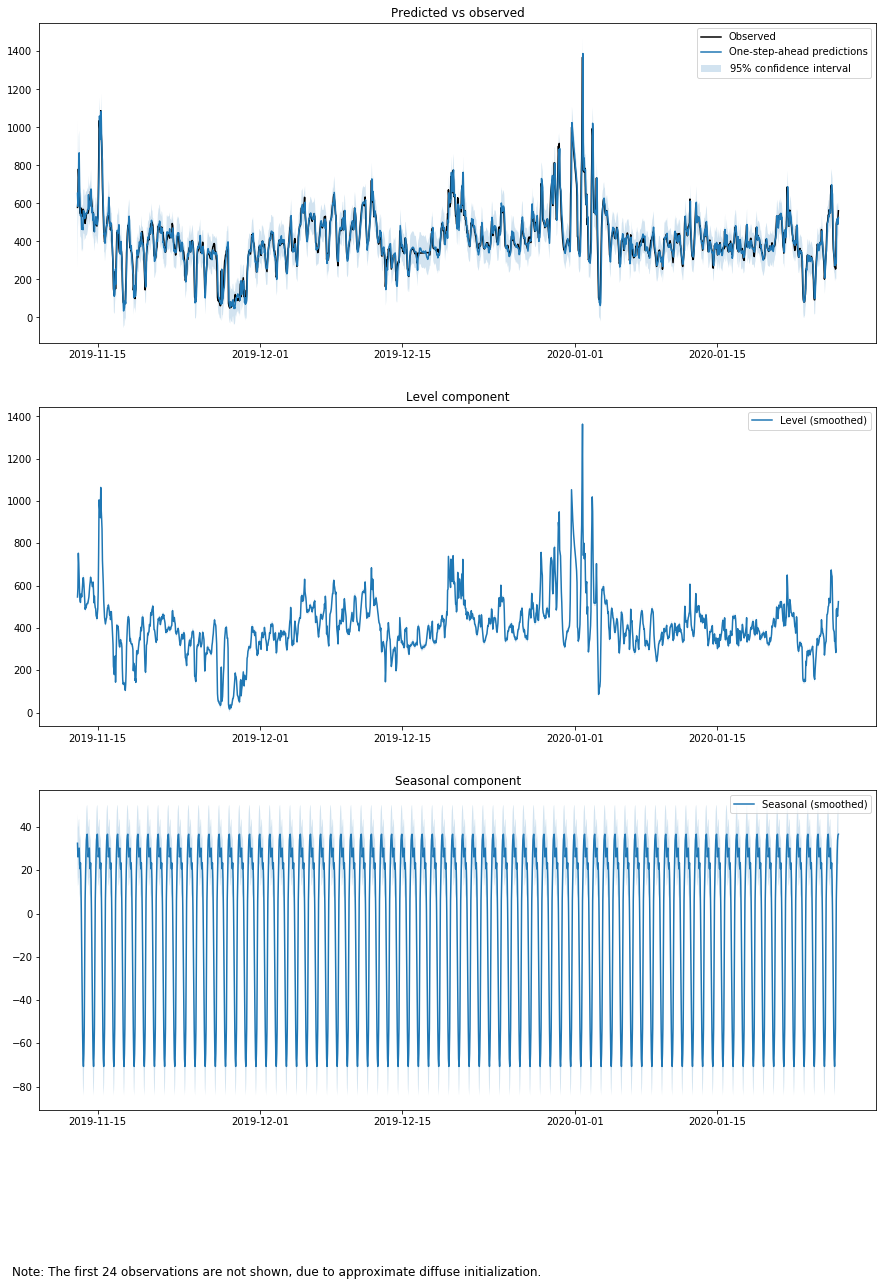

In [33]:
rcParams['figure.figsize'] = 15, 20
fig = result_season_trend.plot_components()